In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
with zipfile.ZipFile("./train_2v.csv.zip") as f:
    df = pd.read_csv(f.open("train_2v.csv"))

del df['id']
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [3]:
df.nunique()

gender                   3
age                    104
hypertension             2
heart_disease            2
ever_married             2
work_type                5
Residence_type           2
avg_glucose_level    12543
bmi                    555
smoking_status           3
stroke                   2
dtype: int64

In [4]:
stroke_mask = df.stroke == 1
nstroke_mask = df.stroke == 0

Stroke(Left) vs Non-Stroke(Right)


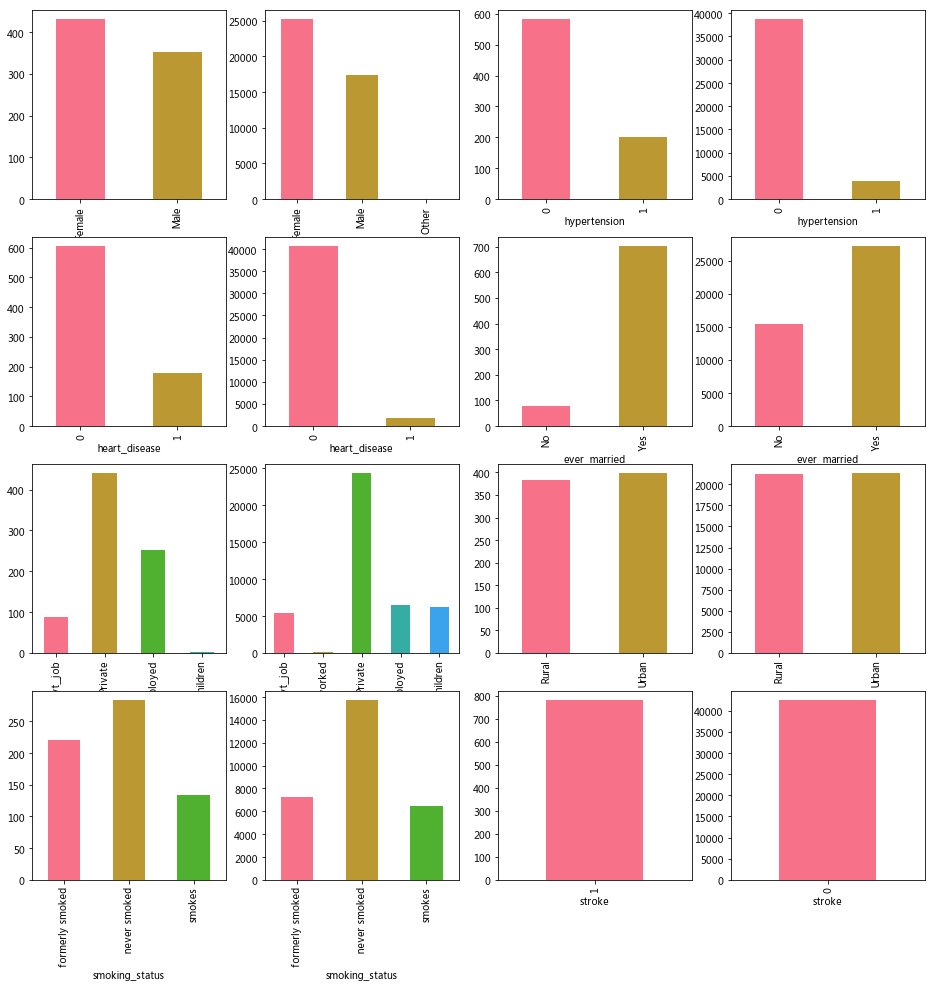

In [5]:
cnt_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

sns.set_palette("husl")
plt.figure(figsize=(16, 16))
print("Stroke(Left) vs Non-Stroke(Right)")
for ind, col in enumerate(cnt_cols):
    plt.subplot(4, 4, ind * 2 + 1)
    df[stroke_mask].groupby(col).size().plot(kind="bar")
    plt.subplot(4, 4, ind * 2 + 2)
    df[nstroke_mask].groupby(col).size().plot(kind="bar")

/home/heyrict/pyenv/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



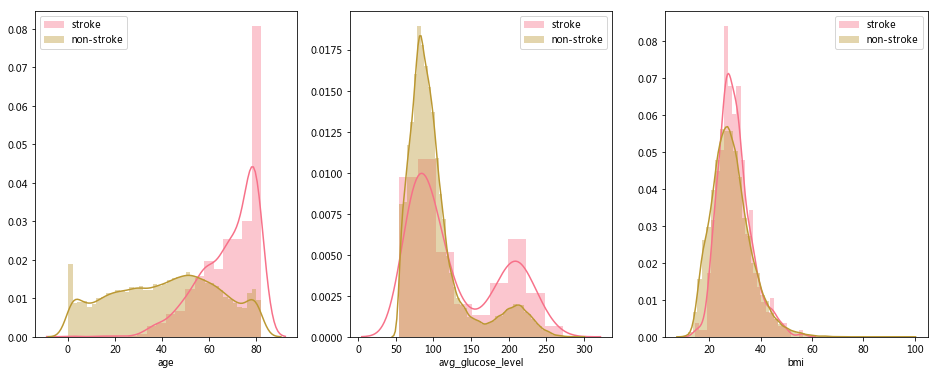

In [6]:
numer_cols = ['age', 'avg_glucose_level', 'bmi']

sns.set_palette("husl")
plt.figure(figsize=(16, 6))
for ind, col in enumerate(numer_cols):
    plt.subplot(1, 3, ind + 1)
    sns.distplot(df.loc[stroke_mask, col].dropna(), label="stroke")
    sns.distplot(df.loc[nstroke_mask, col].dropna(), label="non-stroke")
    plt.legend()

In [7]:
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
enc = {}
for col in cat_cols:
    enc[col] = df[col].unique()

enc

{'gender': array(['Male', 'Female', 'Other'], dtype=object),
 'ever_married': array(['No', 'Yes'], dtype=object),
 'work_type': array(['children', 'Private', 'Never_worked', 'Self-employed', 'Govt_job'],
       dtype=object),
 'Residence_type': array(['Rural', 'Urban'], dtype=object),
 'smoking_status': array([nan, 'never smoked', 'formerly smoked', 'smokes'], dtype=object)}

# Logistic Regression

In [8]:
def preprocess(X):
    returns = X.copy()
    for col in cat_cols:
        for val in enc[col]:
            returns["%s__%s" % (col, val)] = (returns[col] == val).map(int)
        del returns[col]
    return returns

In [9]:
train = df.dropna(subset=["bmi"])
X = preprocess(train.iloc[:, :-1])
y = train.iloc[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()

# train_X = scaler.fit_transform(train_X)
# test_X = scaler.transform(test_X)

# scaler.mean_, scaler.var_

model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
model.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

AUC = 0.8582926997959677


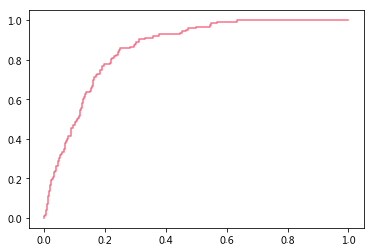

In [10]:
pred_y = model.predict_proba(test_X)[:, 1]
auc = roc_auc_score(test_y, pred_y)
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
print("AUC =", auc)
plt.plot(fpr, tpr)

In [11]:
model.coef_, model.intercept_

(array([[ 0.07624567,  0.58732495,  0.62531765,  0.00383891,  0.008927  ,
         -0.7874647 , -0.88882866, -0.53077427, -1.06084544, -1.14622218,
         -0.27454189, -0.24202829, -1.27783671, -0.10599666, -0.30666408,
         -1.18384372, -1.0232239 ,  0.        ,  0.22783205,  0.19205192,
          0.50386372]]), array([-2.20706762]))

In [12]:
X.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender__Male', 'gender__Female', 'gender__Other', 'ever_married__No',
       'ever_married__Yes', 'work_type__children', 'work_type__Private',
       'work_type__Never_worked', 'work_type__Self-employed',
       'work_type__Govt_job', 'Residence_type__Rural', 'Residence_type__Urban',
       'smoking_status__nan', 'smoking_status__never smoked',
       'smoking_status__formerly smoked', 'smoking_status__smokes'],
      dtype='object')

# LightGBM

In [13]:
import lightgbm as lgb

In [14]:
def preprocess(X):
    returns = X.copy()
    for col in cat_cols:
        enc_col = list(enc[col])
        returns[col] = returns[col].map(lambda x: enc_col.index(x))
    return returns

In [15]:
train = df
X = preprocess(train.iloc[:, :-1])
y = train.iloc[:, -1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=42)
valid_X, test_X, valid_y, test_y = train_test_split(test_X, test_y, test_size=0.5, random_state=42)

train_data = lgb.Dataset(train_X, train_y)
valid_data = lgb.Dataset(valid_X, valid_y)

In [16]:
# def objective(trial):
#     param = {
#         'boost': 'gbdt',
#         'learning_rate': 0.001,
#         'max_depth': trial.suggest_int('max_depth', 4, 7),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 16),
#         'metric': 'auc',
#         'num_threads': 2,
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
#         'tree_learner': 'serial',
#         'verbosity': 0,
#     }

#     clf = lgb.train(
#         param,
#         train_data,
#         10000,
#         valid_sets=[train_data, valid_data],
#         verbose_eval=False,
#         early_stopping_rounds=1000)

#     return clf.best_score['valid_1']['auc']

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)

# study.best_params

In [17]:
param = {
    'boost': 'gbdt',
    'learning_rate': 0.001,
    'max_depth': 5,
    'num_leaves': 6,
    'metric': 'auc',
    'num_threads': 2,
    'min_data_in_leaf': 20,
    'tree_learner': 'serial',
    'verbosity': 1,
}

clf = lgb.train(
    param,
    train_data,
    10000,
    valid_sets=[train_data, valid_data],
    verbose_eval=500,
    early_stopping_rounds=1000)

Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.855239	valid_1's auc: 0.848654
[1000]	training's auc: 0.862163	valid_1's auc: 0.851309
[1500]	training's auc: 0.865552	valid_1's auc: 0.853798
[2000]	training's auc: 0.871358	valid_1's auc: 0.857834
[2500]	training's auc: 0.873222	valid_1's auc: 0.857726
[3000]	training's auc: 0.874427	valid_1's auc: 0.85899
[3500]	training's auc: 0.876099	valid_1's auc: 0.859991
[4000]	training's auc: 0.877414	valid_1's auc: 0.860159
[4500]	training's auc: 0.879542	valid_1's auc: 0.860048
[5000]	training's auc: 0.881617	valid_1's auc: 0.859863
Early stopping, best iteration is:
[4206]	training's auc: 0.878176	valid_1's auc: 0.860817


AUC = 0.869512355530921


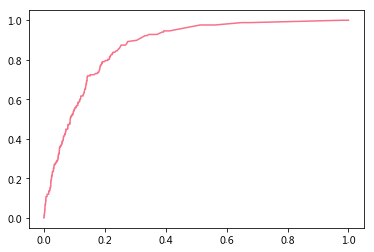

In [18]:
pred_y = clf.predict(test_X)
auc = roc_auc_score(test_y, pred_y)
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
print("AUC =", auc)
plt.plot(fpr, tpr)